In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

In [110]:
file_path = r'voltage_diff\1 kv na22.Spe'

numbers = []
within_data_section = False
mca_cal_value = None

with open(file_path, 'r') as file:
    for line in file:
        if line.strip() == "$DATA:":
            within_data_section = True
            continue
        
        if line.strip() == "$ROI:":
            within_data_section = False
        
        if within_data_section:
            try:
                num = float(line.split()[0])
                numbers.append(num)
            except ValueError:
                continue

        if line.strip() == "$MCA_CAL:":
            for _ in range(3):
                cal_line = file.readline()
                if cal_line:
                    parts = cal_line.split()
                    if len(parts) >= 2:
                        try:
                            mca_cal_value = float(parts[1])
                        except ValueError:
                            pass
counts = np.array(numbers[1:])
mca = mca_cal_value
bins = np.array(range(1,1+np.size(counts)))

print(f'counts prossesed - {np.sum(counts)}, mca value - {mca}, number of bins - {np.size(bins)}')

counts prossesed - 306948.0, mca value - 0.1868748, number of bins - 8192


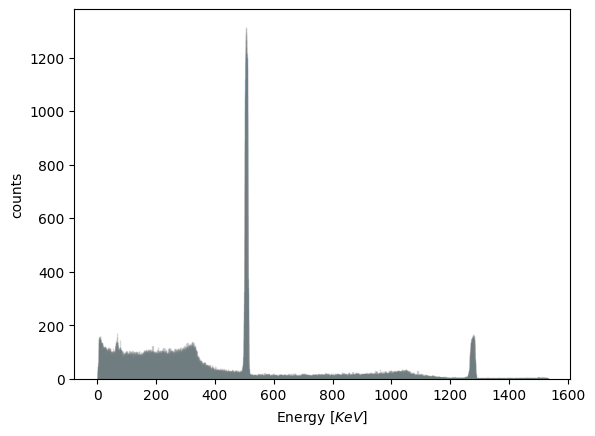

In [111]:
d=100
energy = bins*mca

plt.bar(energy, counts, edgecolor='grey', alpha = 0.3)

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts')
plt.show()

[np.int64(2709), np.int64(6835)]


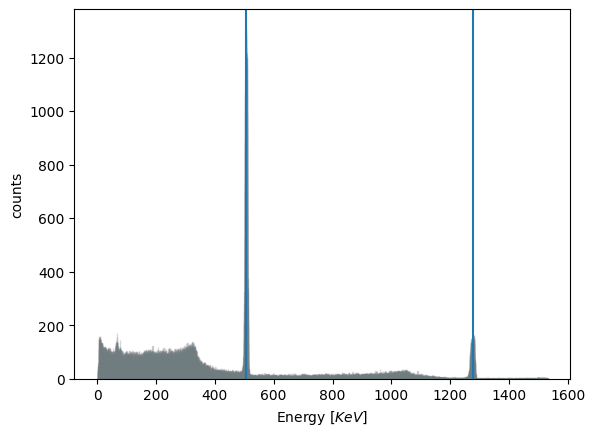

In [121]:
peak_indices, peak_dict = sc.signal.find_peaks(counts[energy > 400], prominence = 100, height=1, width=10)
peak_heights = peak_dict['peak_heights']
peak_indices=peak_indices + int(400/mca)

peaks = [peak_indices[np.argmax(peak_heights)], peak_indices[np.argpartition(peak_heights,-2)[-2]]]
num = np.size(peaks)

print(peaks)

plt.bar(energy, counts, edgecolor='grey', alpha = 0.3)
[plt.axvline(x = energy[c]) for c in peaks]

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts')
plt.show()

In [113]:
width = 100

def gaussian(x, amp, mean, std_dev):
    return amp * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

param_array = np.zeros((num,3))
covariance_array = np.zeros((num,4))
fitted_gaussians = np.zeros((num,width*2))
fwhm_array = np.zeros((num,1))


for c in range(0, num):
    initial_guess = [counts[peaks[c]],peaks[c], 1]
    popt, pcov = sc.optimize.curve_fit(gaussian, bins[peaks[c]-width:peaks[c]+width], counts[peaks[c]-width:peaks[c]+width], p0=initial_guess)

    popt[1:] = popt[1:]*mca
    param_array[c] = popt
    covariance_array[c] = [np.linalg.cond(pcov), *np.diag(pcov)]
    fitted_gaussians[c] = gaussian(bins[peaks[c]-width:peaks[c]+width], *popt)
    fwhm_array[c] = 2 * np.sqrt(2 * np.log(2)) * popt[2]

    print(f"Peak {c+1}:")
    print(f"  Amplitude = {popt[0]:.2f}, Mean = {popt[1]:.2f} keV, Std Dev = {popt[2]:.2f} keV")
    print(f"  FWHM = {fwhm_array[c][0]:.2f} keV")
    print(f"  Covariance Condition Number = {covariance_array[c][0]:.2e}")
    print(f"  Covariance Diagonal (Variance of Amplitude, Mean, Std Dev) = {covariance_array[c][1]:.2e}, {covariance_array[c][2]:.2e}, {covariance_array[c][3]:.2e}")
    print("--------------------------------------------------------------")


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

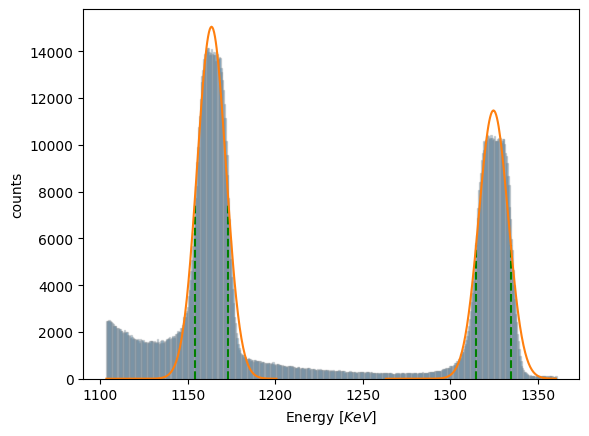

In [107]:
d=100
energy = bins*mca

plt.bar(energy[min(peaks)-d:max(peaks)+d], counts[min(peaks)-d:max(peaks)+d], edgecolor='grey', alpha = 0.3)
[plt.plot([param_array[c][1]-fwhm_array[c]/2,param_array[c][1]-fwhm_array[c]/2], [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'g') for c in range(0,num)]
[plt.plot([param_array[c][1]+fwhm_array[c]/2,param_array[c][1]+fwhm_array[c]/2], [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'g') for c in range(0,num)]
[plt.plot(energy[peaks[c]-width:peaks[c]+width], gaussian(energy[peaks[c]-width:peaks[c]+width], *param_array[c]), c='tab:orange') for c in range(0, num)]

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts')
plt.show()